<font color = blue><font size = 6> 실험설명 </font></font><br>
Pytorch의 모델 구성의 기본을 study하면서 seq2seq의 many to one을 구현해볼 것이다 이를 위해서는 Decoder에 Encoder의 cell과 hidden state와 함께 마지막 data를 넣어주어야 한다 <br>
여기서 진행할 실험은
<font color = blue>정답 값이 들어올 때 훈련없이 그 정답 값을 이용해서 다음 값을 예측한 것이다</font><br>

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [30]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [31]:
use_col = ['volumn']
data = pd.read_csv('../traffic/data/5.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.739264
1,0.737200
2,0.759168
3,0.741552
4,0.749392
...,...
38875,0.652168
38876,0.664736
38877,0.678984
38878,0.653888


<AxesSubplot: >

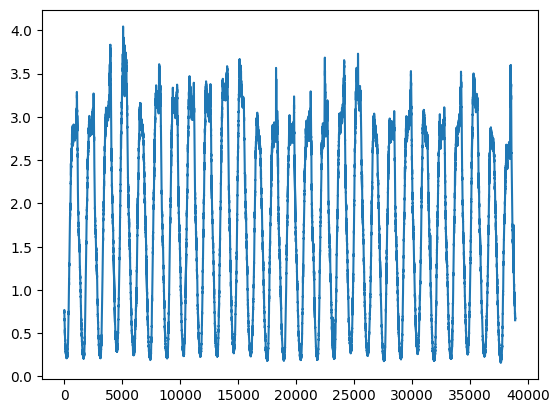

In [32]:
data['value'].plot()

In [33]:
import configparser
import os
config = configparser.ConfigParser()
config['1step_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':8,
}
with open('1step_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'1step_seq2seq')

['/hdd_1/sjlee/Paper_Project/1step_seq2seq']

In [34]:
class Encoder(nn.Module):
    def __init__(self,configs):
        super(Encoder,self).__init__()
        self.input_size = int(configs['1step_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['1step_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['1step_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden


In [35]:
class Decoder(nn.Module):
    def __init__(self,configs):
        super(Decoder,self).__init__()
        self.input_size = int(configs['1step_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['1step_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['1step_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        output = self.linear(lstm_out)
        
        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [36]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.encoder = Encoder(configs)
        self.decoder = Decoder(configs)
        
    def forward(self,x):
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        _,final_hidden = self.encoder(x)
        output,_ = self.decoder(x = x[:,-1,:].view(-1,1,1),encoder_hidden = final_hidden)
        
        return output

In [37]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [38]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'values':data[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [39]:
x_seq

tensor([[[0.7393, 0.7372, 0.7592,  ..., 0.7869, 0.7698, 0.7890]],

        [[0.7372, 0.7592, 0.7416,  ..., 0.7698, 0.7890, 0.7862]],

        [[0.7592, 0.7416, 0.7494,  ..., 0.7890, 0.7862, 0.7815]],

        ...,

        [[0.6223, 0.6152, 0.5962,  ..., 0.7110, 0.6959, 0.6959]],

        [[0.6152, 0.5962, 0.6145,  ..., 0.6959, 0.6959, 0.6893]],

        [[0.5962, 0.6145, 0.6112,  ..., 0.6959, 0.6893, 0.6990]]],
       device='cuda:0')

In [40]:
import torch.optim as optim

In [41]:
device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),8*1e-5)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 8.0000e-05.


https://justkode.kr/deep-learning/pytorch-save <br>
모델 저장 및 불러오기

In [42]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
        
        out = model(seq).to(device)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 7.6000e-05.
smape 89.26253932239541 %
Adjusting learning rate of group 0 to 7.2200e-05.
smape 51.23383338470556 %
Adjusting learning rate of group 0 to 6.8590e-05.
smape 27.785874057495803 %
Adjusting learning rate of group 0 to 6.5161e-05.
smape 20.069574269504226 %
Adjusting learning rate of group 0 to 6.1902e-05.
smape 16.49615340806239 %
Adjusting learning rate of group 0 to 5.8807e-05.
smape 13.861166154911295 %
Adjusting learning rate of group 0 to 5.5867e-05.
smape 11.752752179704737 %
Adjusting learning rate of group 0 to 5.3074e-05.
smape 10.084859219254458 %
Adjusting learning rate of group 0 to 5.0420e-05.
smape 9.06363846750505 %
Adjusting learning rate of group 0 to 4.7899e-05.
smape 8.560954578907081 %
Adjusting learning rate of group 0 to 4.5504e-05.
smape 8.26796772628369 %
Adjusting learning rate of group 0 to 4.3229e-05.
smape 8.05168185257816 %
Adjusting learning rate of group 0 to 4.1067e-05.
smape 7.875744727009919 %
Adjusting 

In [50]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []
for idx in range(split):
    running_loss = 0.0
    start = time.time()
    if idx == 0:
        new_train = torch.FloatTensor(
        [X.iloc[-sequence_length:].values]).view(1,sequence_length,1).to(device)
                
    elif idx < sequence_length:
        new_train = torch.FloatTensor(
            [pd.concat([X.iloc[-sequence_length+idx:],target.iloc[0:idx]],axis=0,ignore_index=True).values]
            ).view(1,sequence_length,1).to(device)
    elif idx >= sequence_length:
        new_train = torch.FloatTensor(
            [target.iloc[idx-sequence_length:idx].values]
            ).view(1,sequence_length,1).to(device)

    with torch.no_grad():
        model.eval()
        out = model(new_train).to(device) # 예측완료
        end = time.time()
        pred_list.append(out.cpu().view(1).item())
        time_list.append(end-start)

In [51]:
len(pred_list)

10080

In [52]:
target = target.values.reshape(-1,1)
score=SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 2.03305983543396 %


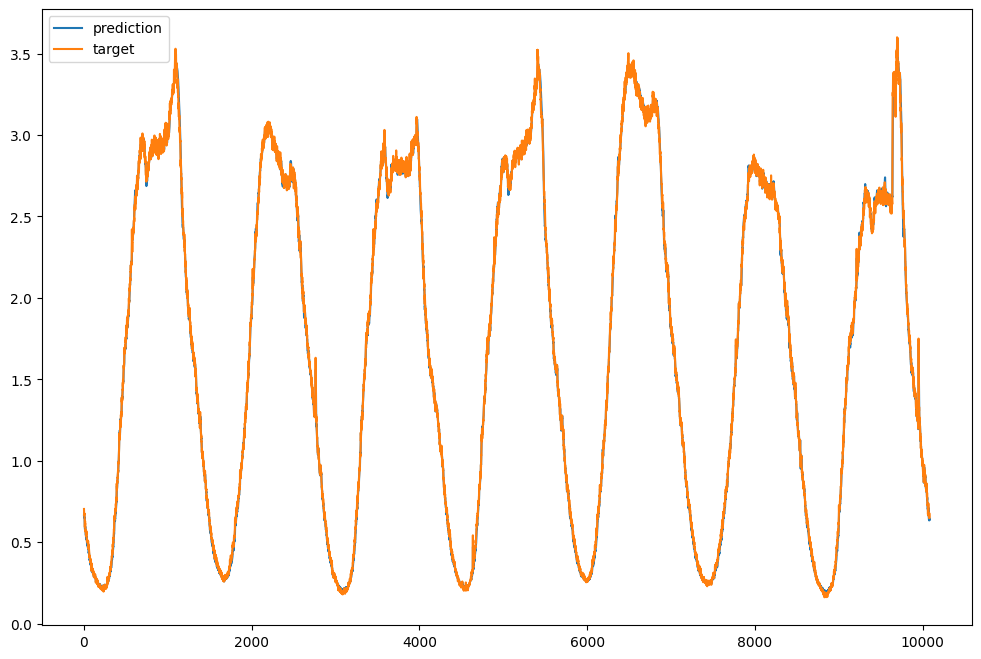

In [53]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

scaling을 해서 차이가 얼마 안나 보이는 거지 scale을 원래대로 돌리면 차이가 확연하게 보일 것 이다

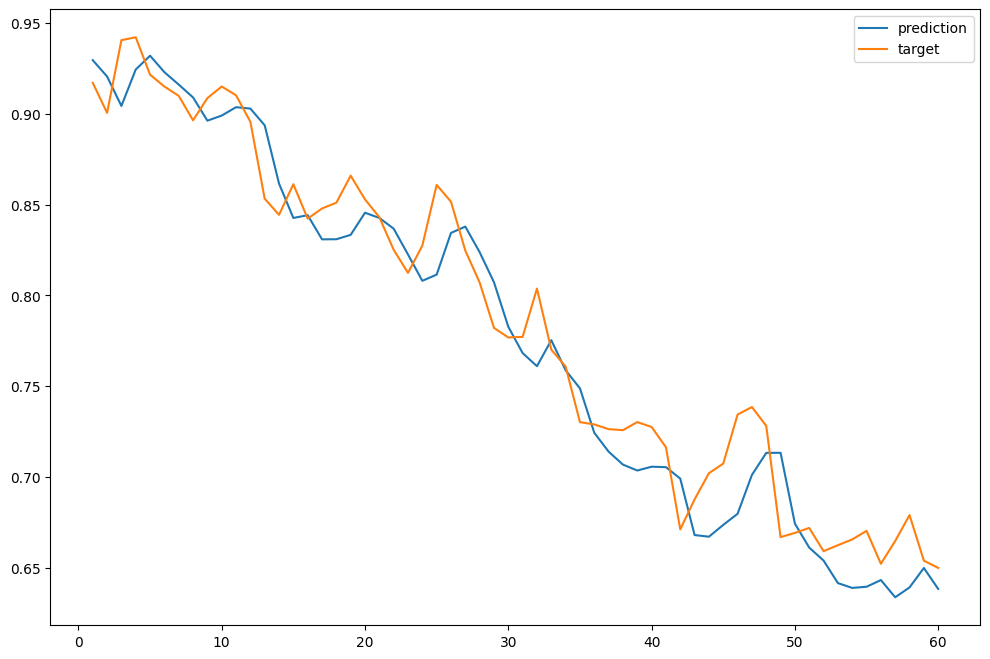

In [54]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [55]:
np.mean(time_list)

0.0022164550092485216

<font color = blue><font size = 6> Conclusion </font></font><br>
DLinear와 NLinear에 비해서 모델도 복잡하고 정확도도 떨어져서 RNN계열은 1step point forecasting에 적합하지 않은것으로 판단된다